In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '2'

from pytorch_lightning import utilities as pl_utils
from pytorch_lightning.trainer.trainer import Trainer
from pytorch_lightning.plugins import DDPPlugin
import torch
import pathlib, itertools
from functools import partial
import sys, glob, copy
import numpy as np

sys.path.append('..')
sys.path.append('../deep-learning-base')
sys.path.append('../deep-learning-base/training')
sys.path.append('../deep-learning-base/datasets')
sys.path.append('../partially_inverted_reps')

import plot_helper as plt_hp
import output as out
from training import LitProgressBar, NicerModelCheckpointing
import training.finetuning as ft
import architectures as arch
from architectures.callbacks import LightningWrapper, LinearEvalWrapper
from attack.callbacks import AdvCallback
from data_modules import DATA_MODULES
import dataset_metadata as dsmd
from partial_loss import PartialInversionLoss, PartialInversionRegularizedLoss
from __init__ import DATA_PATH_IMAGENET, DATA_PATH, SERVER_PROJECT_PATH
from human_nn_alignment.save_inverted_reps import save_batched_images, get_classes_names

/NS/twitter_archive2/work/vnanda/minconda3/envs/dl_base/lib/python3.7/site-packages/paramiko/transport.py:236: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [32]:
CHECKPOINT_PATHS = {
    'resnet50': {
        'nonrob': '',
        'robustl2eps3': '/NS/robustness_3/work/vnanda/adv-robustness/logs/'\
                        'robust_imagenet/eps3/resnet-50-l2-eps3.ckpt'
        },
    'wide_resnet50_2': {
        'nonrob': '/NS/robustness_3/work/vnanda/adv-robustness/logs/'\
                  'robust_imagenet/eps0/wideresnet-50-2-nonrob.ckpt',
        'robustl2eps3': '/NS/robustness_3/work/vnanda/adv-robustness/logs/'\
                        'robust_imagenet/eps3/wideresnet-50-2-l2-eps3.ckpt'},
    'resnet18': {
        'nonrob': '',
        'robustl2eps3': '/NS/robustness_3/work/vnanda/adv-robustness/logs/'\
                        'robust_imagenet/eps3/resnet-18-l2-eps3.ckpt'},
    'resnet50_mrl': {
        'nonrob': '/NS/robustness_2/work/vnanda/invariances_in_reps/deep-learning-base/checkpoints'\
                  '/imagenet1k/r50_mrl1_e0_ff2048.pt'
        },
    'vit_small_patch16_224': {
        'nonrob': \
            '/NS/robustness_2/work/vnanda/invariances_in_reps/deep-learning-base/checkpoints/imagenet21k/'\
            'S_16-i21k-300ep-lr_0.001-aug_light1-wd_0.03-do_0.0-sd_0.0.npz'
        },
    'vit_small_patch32_224': {
        'nonrob': \
            '/NS/robustness_2/work/vnanda/invariances_in_reps/deep-learning-base/checkpoints/imagenet21k/'\
            'S_32-i21k-300ep-lr_0.001-aug_light1-wd_0.03-do_0.0-sd_0.0.npz'
        },
    'vgg16_bn': {
        'nonrob': '',
        'robustl2eps3': '/NS/robustness_3/work/vnanda/adv-robustness/logs/'\
                        'robust_imagenet/eps3/vgg16_bn_l2_eps3.ckpt'}
}

SEED = 2
NUM_NODES = 1
DEVICES = 1
BASE_DIR = f"{pathlib.Path('.').parent.resolve()}/checkpoints"

FINETUNING_DATASETS = ['cifar10'] #, 'cifar100', 'flowers', 'oxford-iiit-pets']
FINETUNE_BS = 256
EVAL_BATCH_SIZE = 200

In [33]:
def load_linear_weights(model, state_dict):
    linear_layer = list(model.named_modules())[-1][1]
    linear_layer.load_state_dict({'.'.join(k.split('.')[-1:]):v \
                                  for k,v in state_dict['state_dict'].items()}, strict=True)
    if hasattr(linear_layer, 'neuron_indices') and 'neuron_indices' in state_dict:
        assert torch.all(linear_layer.neuron_indices == state_dict['neuron_indices'])

In [34]:
## Source: https://github.com/oliviaguest/gini/blob/master/gini.py
def gini(array):
    """Calculate the Gini coefficient of a numpy array."""
    # based on bottom eq:
    # http://www.statsdirect.com/help/generatedimages/equations/equation154.svg
    # from:
    # http://www.statsdirect.com/help/default.htm#nonparametric_methods/gini.htm
    # All values are treated equally, arrays must be 1d:
    array = array.flatten()
    if np.amin(array) < 0:
        # Values cannot be negative:
        array -= np.amin(array)
    # Values cannot be 0:
    array += 0.0000001
    # Values must be sorted:
    array = np.sort(array)
    # Index per array element:
    index = np.arange(1,array.shape[0]+1)
    # Number of array elements:
    n = array.shape[0]
    # Gini coefficient:
    return ((np.sum((2 * index - n  - 1) * array)) / (n * np.sum(array)))

def maxmin(array):
    return np.max(array) - np.min(array)

def tv(array):
    return np.var(array) ** 0.5 / np.mean(array)

In [35]:
def load_predictions(model_path):
    preds_path = f'{model_path.split(".ckpt")[0]}.pred'
    if os.path.exists(preds_path):
        return torch.load(preds_path)

def calc_accs(m1, dm, checkpoints, frac, finetuning_dataset):    
    class_to_acc, overall = {}, []
    for model_path in checkpoints:
        loaded_preds = load_predictions(model_path)
        if loaded_preds is not None:
            pred, y = torch.argmax(loaded_preds['pred'], 1), loaded_preds['gt']
        else:
            seed = int(model_path.split('-seed-')[1].split('-')[0])
            sd = torch.load(model_path)
            layer = ft.setup_model_for_finetuning(
                m1.model, 
                dsmd.DATASET_PARAMS[finetuning_dataset]['num_classes'],
                FINETUNE_MODE, frac, seed, inplace=True)
            load_linear_weights(m1.model, sd)        
            pl_utils.seed.seed_everything(SEED, workers=True)
            trainer = Trainer(accelerator='gpu', 
                              devices=DEVICES,
                              num_nodes=NUM_NODES,
                              log_every_n_steps=1,
                              auto_select_gpus=True, 
                              deterministic=True,
                              check_val_every_n_epoch=1,
                              num_sanity_val_steps=0,
                              callbacks=[LitProgressBar(['loss', 'running_test_acc'])])
            out = trainer.predict(m1, dataloaders=[dm.test_dataloader()])
            pred, y = torch.argmax(out[0], 1), out[1]
        
        overall.append(torch.sum(pred == y).item()/len(y))
        unique_classes = list(set(y.numpy()))
        for c in unique_classes:
            mask = y == c
            if c in class_to_acc:
                class_to_acc[c].append(torch.sum(pred[mask] == y[mask])/torch.sum(mask))
            else:
                class_to_acc[c] = [torch.sum(pred[mask] == y[mask])/torch.sum(mask)]
    return class_to_acc, overall

def get_classwise_errors(model, source_dataset, finetuning_dataset, checkpoint_path, 
                         append, FRACTIONS_OR_NUMBERS=None):
    dm = DATA_MODULES[finetuning_dataset](
        data_dir=DATA_PATH_IMAGENET if 'imagenet' in finetuning_dataset else DATA_PATH,
        transform_train=dsmd.TRAIN_TRANSFORMS_TRANSFER_DEFAULT(224),
        transform_test=dsmd.TEST_TRANSFORMS_DEFAULT(224),
        batch_size=EVAL_BATCH_SIZE)
    dm.init_remaining_attrs(source_dataset)

    ## assign mean and std from source dataset
    m1 = arch.create_model(model, source_dataset, pretrained=True,
                           checkpoint_path=checkpoint_path, seed=SEED, 
                           num_classes=dsmd.DATASET_PARAMS[source_dataset]['num_classes'],
                           callback=partial(LightningWrapper, 
                                            dataset_name=source_dataset),
                           loading_function_kwargs={'strict': False})
    og_model = copy.deepcopy(m1.model)
    
    if FRACTIONS_OR_NUMBERS is None:
        FRACTIONS_OR_NUMBERS = sorted(list(set(
            [float(x.split('/frac-')[1].split('-')[0]) for x in \
             glob.glob(f'./checkpoints/{model}-base-'
                       f'{source_dataset}-ft-{finetuning_dataset}/'
                       f'*-bs-256-{append}/*') \
             if len(x.split('/frac-')[1].split('-')[0]) == 7 and \
                'full-feature' not in x.split('/')[-1] and \
                'layer' not in x.split('/')[-1] and \
                'pool' not in x.split('/')[-1]])))
    
    classwise_accs = {} # each value is a dict from class_index to a list of accuracies
    overall_accs = {}
    for frac in FRACTIONS_OR_NUMBERS:
        if isinstance(frac, int):
            actual_fraction = frac / FRACTIONS_OR_NUMBERS[-1]
        else:
            actual_fraction = frac
        checkpoint_paths = [x for x in glob.glob(
            f'{BASE_DIR}/{model}-base-{source_dataset}-ft-{finetuning_dataset}/'
            f'frac-{actual_fraction:.5f}-mode-{FINETUNE_MODE}-seed-*-'
            f'ftmode-linear-lr-*-bs*-{append}/*-topk=1.ckpt') \
                if 'layer' not in x.split('/')[-1] and \
                   'pool' not in x.split('/')[-1] and \
                   'full-feature' not in x.split('/')[-1]]
        m1.model = copy.deepcopy(og_model)
        classwise, overall = calc_accs(m1, dm, checkpoint_paths, actual_fraction, finetuning_dataset)
        classwise_accs[frac] = classwise
        overall_accs[frac] = overall
    
    class_names = get_classes_names(finetuning_dataset, 
                                    DATA_PATH_IMAGENET if 'imagenet' in finetuning_dataset else DATA_PATH)
    classwise_heatmap = np.full((len(class_names), len(FRACTIONS_OR_NUMBERS)), np.nan)
    for i, frac in enumerate(FRACTIONS_OR_NUMBERS):
        for c, accs in sorted(classwise_accs[frac].items(), key=lambda x: x[0]):
            classwise_heatmap[c, i] = np.nanmean(accs)
    
    return classwise_heatmap, overall_accs, plt_hp.get_wiki_link(plt_hp.plot_heatmaps(
        [classwise_heatmap], x_labels=FRACTIONS_OR_NUMBERS, 
        y_labels=[class_names[i] for i in range(len(class_names))], 
        plot_title=finetuning_dataset, subplot_titles=None, subfolder=source_dataset, 
        filename=f'{model}-{finetuning_dataset}-{append}-{FINETUNE_MODE}', file_format='png', vmin=0, vmax=1, 
        show_fig=True, cols=None, x_title='Fraction/number of neurons', y_title='Classwise Accuracies (mean)', 
        annotate=True, types=None, paper_friendly_plots=True, annotation_fontsize=7, 
        root_dir='.', figsize=(10,10) if len(class_names) < 50 else (15,30), 
        results_subfolder_name='class_wise_errors'), SERVER_PROJECT_PATH, size=700)

In [36]:
def results(model, source_dataset, FRACTIONS_OR_NUMBERS=None):
    plt_str = '== Classwise Errors on Final Layer ==\n\n'
    model_to_heatmap, model_to_overall = {}, {}
    for append in CHECKPOINT_PATHS[model].keys():
        plt_str += f'=== {model} - {append} - {FINETUNE_MODE} ===\n\n'
        for ft_ds in FINETUNING_DATASETS:
            plt_str += f'==== {ft_ds} ====\n\n'
            classwise_heatmap, overall_accs, error_plt = get_classwise_errors(model, source_dataset, ft_ds, 
                                             CHECKPOINT_PATHS[model][append], append, FRACTIONS_OR_NUMBERS)
            plt_str += f'{error_plt}\n\n'
            model_to_heatmap[f'{model}-{append}-{ft_ds}'] = classwise_heatmap
            model_to_overall[f'{model}-{append}-{ft_ds}'] = overall_accs
    with open(f'./results/class_wise_errors/{source_dataset}/'
              f'wiki_results-{model}-{FINETUNE_MODE}.txt', 'w') as fp:
        fp.write(plt_str)
    out.upload_results(['{}/{}/{}'.format(plt_hp.RESULTS_FOLDER_NAME, 'class_wise_errors', source_dataset)], 
        'results', SERVER_PROJECT_PATH, '.png')
    return model_to_heatmap, model_to_overall

Global seed set to 2


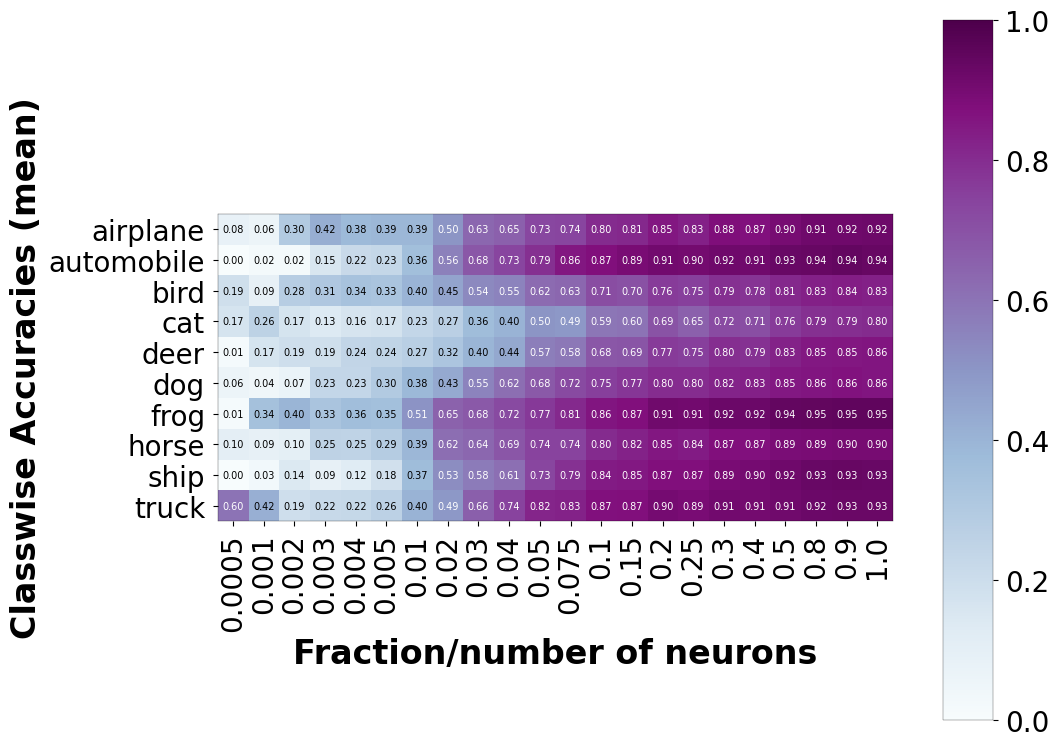

Global seed set to 2


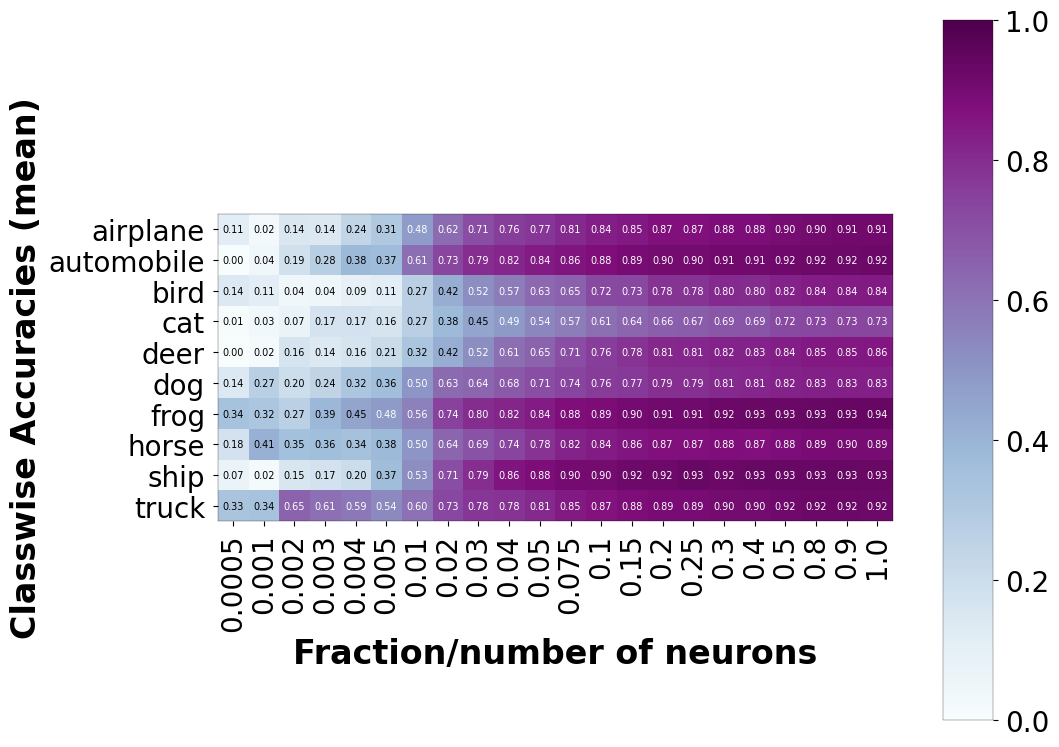

Uploading results in ['results/class_wise_errors/imagenet'] to contact.mpi-sws.org...
Uploading 24 files to server
copying results/class_wise_errors/imagenet/resnet50_mrl-cifar100-nonrob-first.png to /home/vnanda/public_html/results/partially_inverted_reps/class_wise_errors/imagenet/resnet50_mrl-cifar100-nonrob-first.png
copying results/class_wise_errors/imagenet/resnet50-cifar10-nonrob.png to /home/vnanda/public_html/results/partially_inverted_reps/class_wise_errors/imagenet/resnet50-cifar10-nonrob.png
copying results/class_wise_errors/imagenet/resnet50-cifar100-nonrob-random.png to /home/vnanda/public_html/results/partially_inverted_reps/class_wise_errors/imagenet/resnet50-cifar100-nonrob-random.png
copying results/class_wise_errors/imagenet/resnet50-flowers-robustl2eps3.png to /home/vnanda/public_html/results/partially_inverted_reps/class_wise_errors/imagenet/resnet50-flowers-robustl2eps3.png
copying results/class_wise_errors/imagenet/resnet50-cifar10-nonrob-random.png to /home/vnan

In [20]:
MODEL = 'resnet50'
SOURCE_DATASET = 'imagenet'
FINETUNE_MODE = 'random'
resnet50_classwise_accs, resnet50_overall = results(MODEL, SOURCE_DATASET)

Global seed set to 2


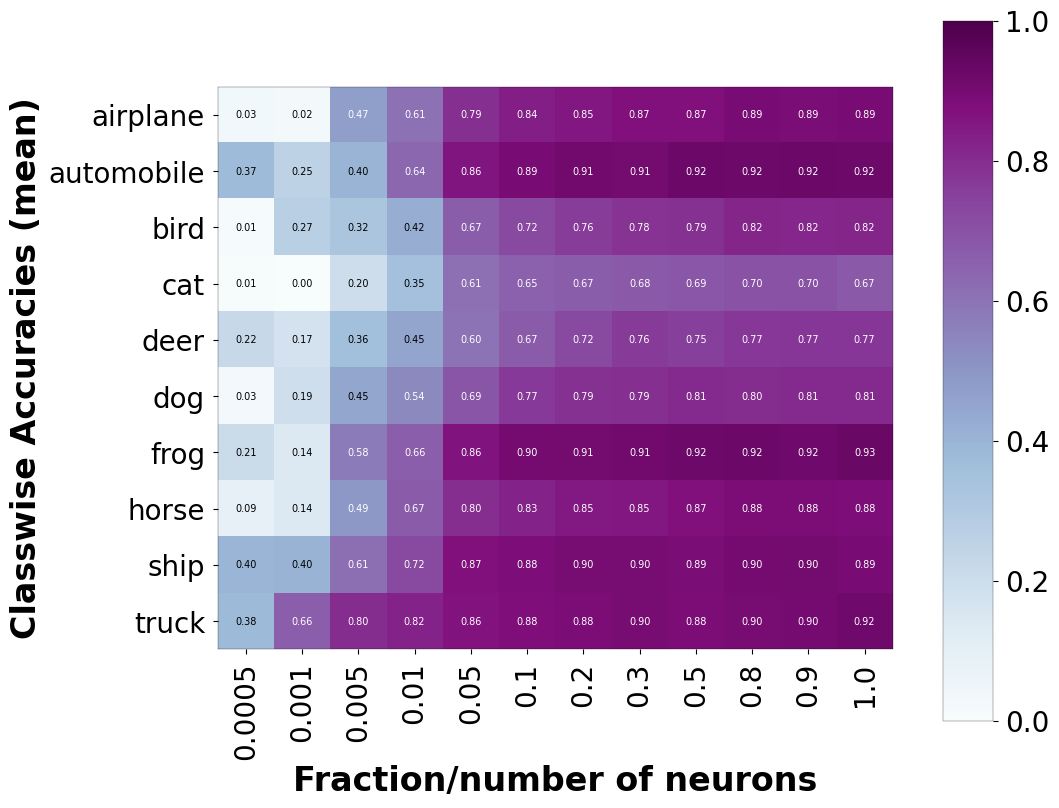

Global seed set to 2


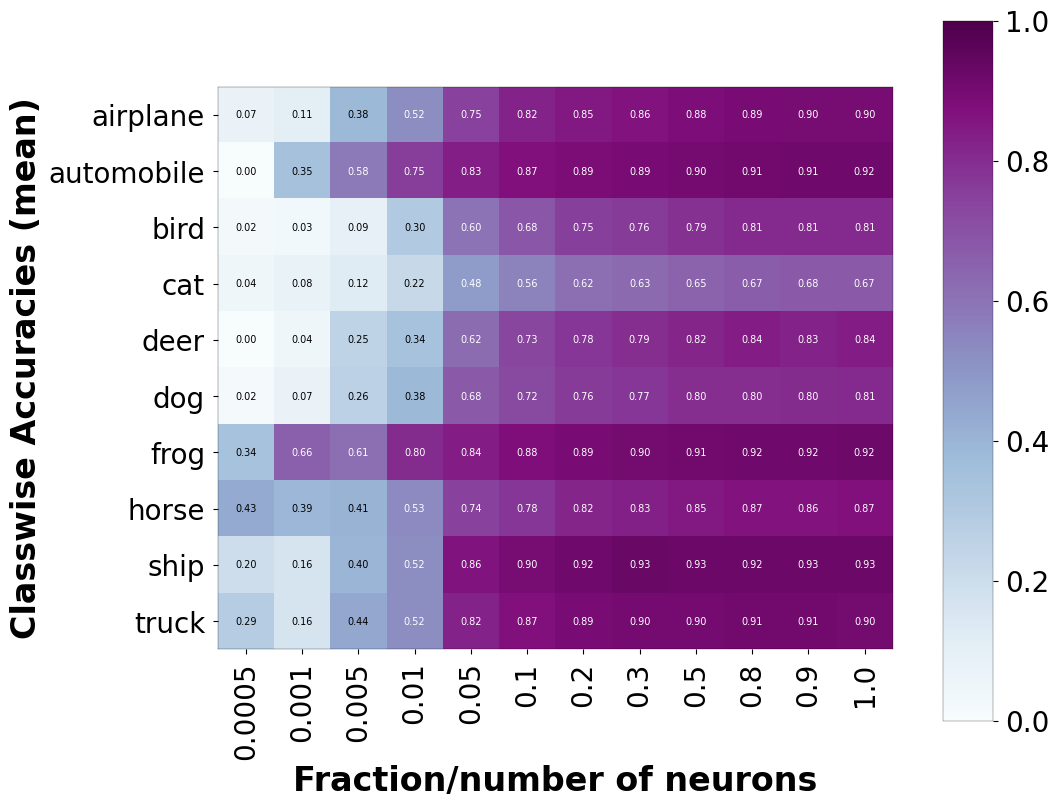

Uploading results in ['results/class_wise_errors/imagenet'] to contact.mpi-sws.org...
Uploading 24 files to server
copying results/class_wise_errors/imagenet/resnet50_mrl-cifar100-nonrob-first.png to /home/vnanda/public_html/results/partially_inverted_reps/class_wise_errors/imagenet/resnet50_mrl-cifar100-nonrob-first.png
copying results/class_wise_errors/imagenet/resnet50-cifar10-nonrob.png to /home/vnanda/public_html/results/partially_inverted_reps/class_wise_errors/imagenet/resnet50-cifar10-nonrob.png
copying results/class_wise_errors/imagenet/resnet50-cifar100-nonrob-random.png to /home/vnanda/public_html/results/partially_inverted_reps/class_wise_errors/imagenet/resnet50-cifar100-nonrob-random.png
copying results/class_wise_errors/imagenet/resnet50-flowers-robustl2eps3.png to /home/vnanda/public_html/results/partially_inverted_reps/class_wise_errors/imagenet/resnet50-flowers-robustl2eps3.png
copying results/class_wise_errors/imagenet/resnet50-cifar10-nonrob-random.png to /home/vnan

In [21]:
MODEL = 'vgg16_bn'
SOURCE_DATASET = 'imagenet'
FINETUNE_MODE = 'random'
vgg16_classwise_accs, vgg16_overall = results(MODEL, SOURCE_DATASET)

Global seed set to 2


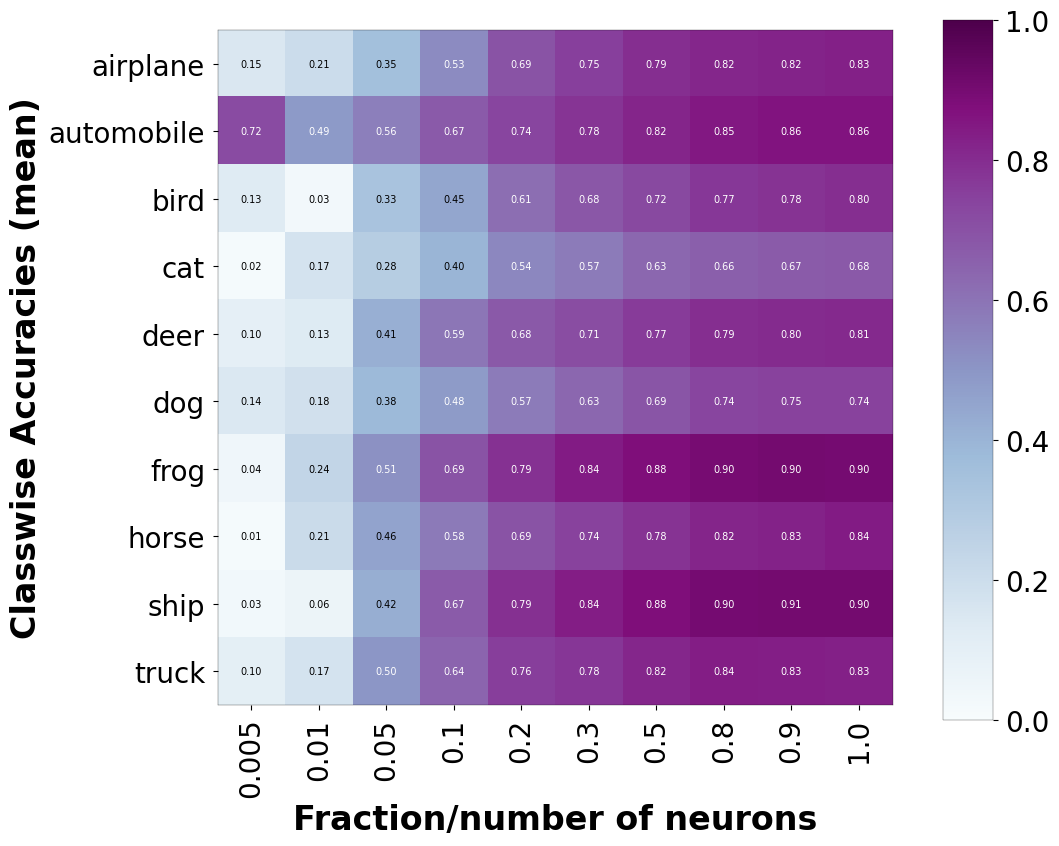

Uploading results in ['results/class_wise_errors/imagenet'] to contact.mpi-sws.org...
Uploading 24 files to server
copying results/class_wise_errors/imagenet/resnet50_mrl-cifar100-nonrob-first.png to /home/vnanda/public_html/results/partially_inverted_reps/class_wise_errors/imagenet/resnet50_mrl-cifar100-nonrob-first.png
copying results/class_wise_errors/imagenet/resnet50-cifar10-nonrob.png to /home/vnanda/public_html/results/partially_inverted_reps/class_wise_errors/imagenet/resnet50-cifar10-nonrob.png
copying results/class_wise_errors/imagenet/resnet50-cifar100-nonrob-random.png to /home/vnanda/public_html/results/partially_inverted_reps/class_wise_errors/imagenet/resnet50-cifar100-nonrob-random.png
copying results/class_wise_errors/imagenet/resnet50-flowers-robustl2eps3.png to /home/vnanda/public_html/results/partially_inverted_reps/class_wise_errors/imagenet/resnet50-flowers-robustl2eps3.png
copying results/class_wise_errors/imagenet/resnet50-cifar10-nonrob-random.png to /home/vnan

In [22]:
MODEL = 'vit_small_patch32_224'
SOURCE_DATASET = 'imagenet'
FINETUNE_MODE = 'random'
vit32_classwise_accs, vit32_overall = results(MODEL, SOURCE_DATASET)

Global seed set to 2


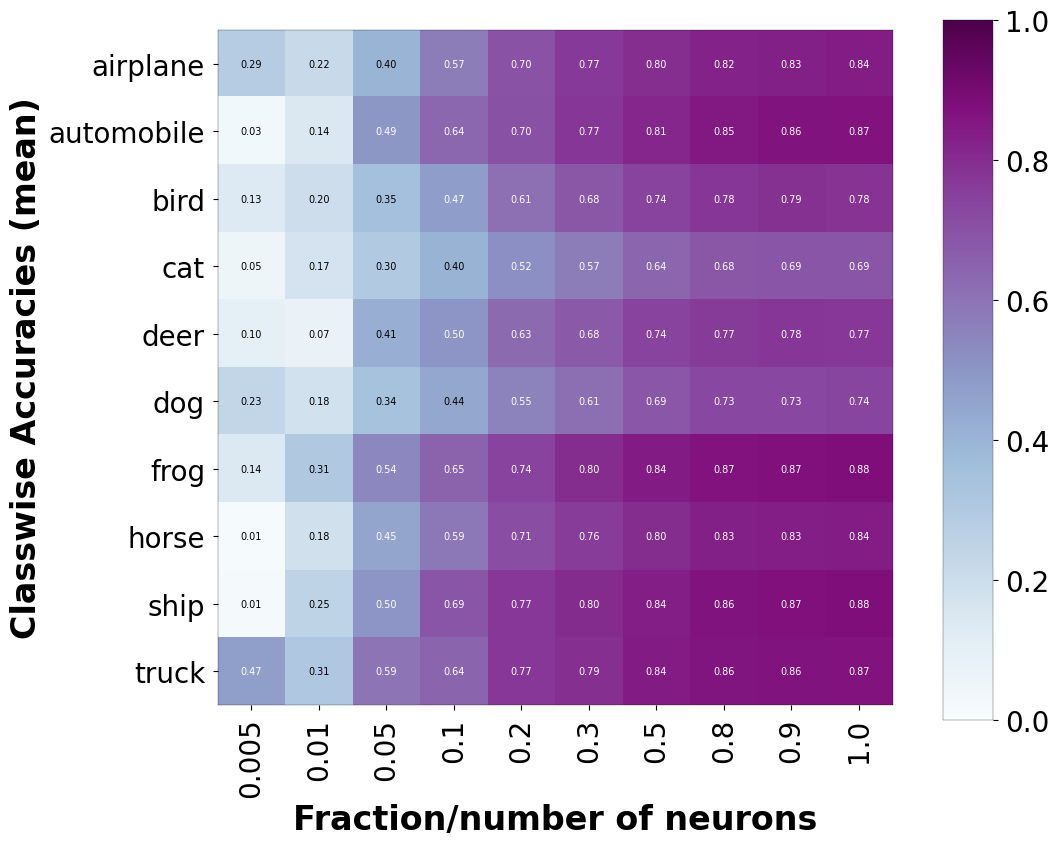

Uploading results in ['results/class_wise_errors/imagenet'] to contact.mpi-sws.org...
Uploading 24 files to server
copying results/class_wise_errors/imagenet/resnet50_mrl-cifar100-nonrob-first.png to /home/vnanda/public_html/results/partially_inverted_reps/class_wise_errors/imagenet/resnet50_mrl-cifar100-nonrob-first.png
copying results/class_wise_errors/imagenet/resnet50-cifar10-nonrob.png to /home/vnanda/public_html/results/partially_inverted_reps/class_wise_errors/imagenet/resnet50-cifar10-nonrob.png
copying results/class_wise_errors/imagenet/resnet50-cifar100-nonrob-random.png to /home/vnanda/public_html/results/partially_inverted_reps/class_wise_errors/imagenet/resnet50-cifar100-nonrob-random.png
copying results/class_wise_errors/imagenet/resnet50-flowers-robustl2eps3.png to /home/vnanda/public_html/results/partially_inverted_reps/class_wise_errors/imagenet/resnet50-flowers-robustl2eps3.png
copying results/class_wise_errors/imagenet/resnet50-cifar10-nonrob-random.png to /home/vnan

In [37]:
MODEL = 'vit_small_patch16_224'
SOURCE_DATASET = 'imagenet'
FINETUNE_MODE = 'random'
vit16_classwise_accs, vit16_overall = results(MODEL, SOURCE_DATASET)

In [ ]:
MODEL = 'vit_small_patch32_224'
SOURCE_DATASET = 'imagenet21k'
FINETUNE_MODE = 'random'
results(MODEL, SOURCE_DATASET)

In [ ]:
MODEL = 'vit_small_patch16_224'
SOURCE_DATASET = 'imagenet21k'
FINETUNE_MODE = 'random'
results(MODEL, SOURCE_DATASET)

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.


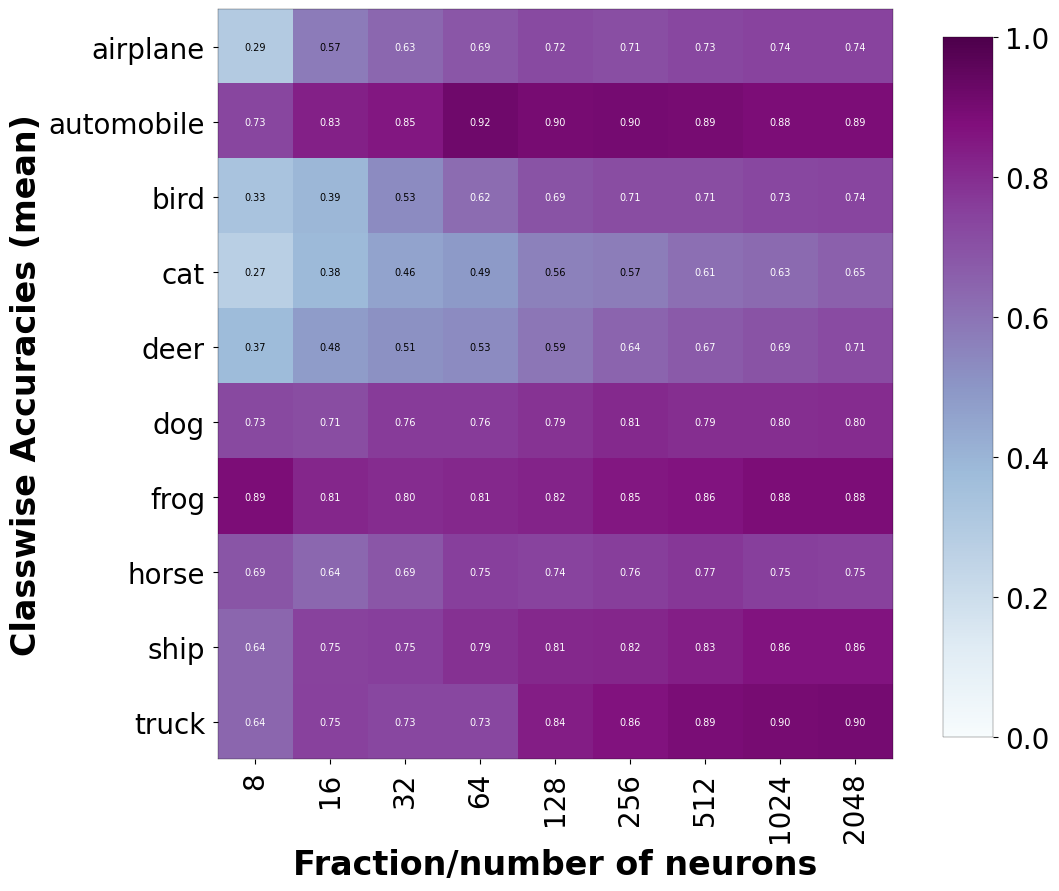

Uploading results in ['results/class_wise_errors/imagenet'] to contact.mpi-sws.org...
Uploading 24 files to server
copying results/class_wise_errors/imagenet/resnet50_mrl-cifar100-nonrob-first.png to /home/vnanda/public_html/results/partially_inverted_reps/class_wise_errors/imagenet/resnet50_mrl-cifar100-nonrob-first.png
copying results/class_wise_errors/imagenet/resnet50-cifar10-nonrob.png to /home/vnanda/public_html/results/partially_inverted_reps/class_wise_errors/imagenet/resnet50-cifar10-nonrob.png
copying results/class_wise_errors/imagenet/resnet50-cifar100-nonrob-random.png to /home/vnanda/public_html/results/partially_inverted_reps/class_wise_errors/imagenet/resnet50-cifar100-nonrob-random.png
copying results/class_wise_errors/imagenet/resnet50-flowers-robustl2eps3.png to /home/vnanda/public_html/results/partially_inverted_reps/class_wise_errors/imagenet/resnet50-flowers-robustl2eps3.png
copying results/class_wise_errors/imagenet/resnet50-cifar10-nonrob-random.png to /home/vnan

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.


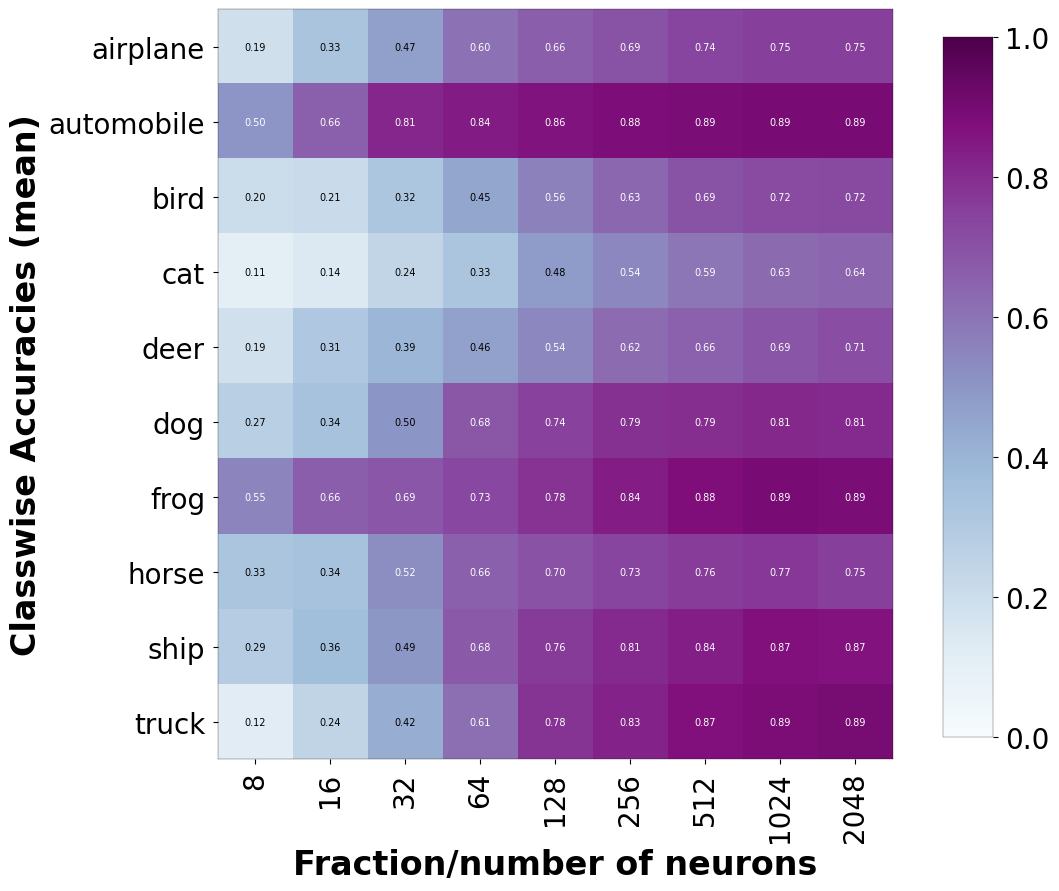

Uploading results in ['results/class_wise_errors/imagenet'] to contact.mpi-sws.org...
Uploading 24 files to server
copying results/class_wise_errors/imagenet/resnet50_mrl-cifar100-nonrob-first.png to /home/vnanda/public_html/results/partially_inverted_reps/class_wise_errors/imagenet/resnet50_mrl-cifar100-nonrob-first.png
copying results/class_wise_errors/imagenet/resnet50-cifar10-nonrob.png to /home/vnanda/public_html/results/partially_inverted_reps/class_wise_errors/imagenet/resnet50-cifar10-nonrob.png
copying results/class_wise_errors/imagenet/resnet50-cifar100-nonrob-random.png to /home/vnanda/public_html/results/partially_inverted_reps/class_wise_errors/imagenet/resnet50-cifar100-nonrob-random.png
copying results/class_wise_errors/imagenet/resnet50-flowers-robustl2eps3.png to /home/vnanda/public_html/results/partially_inverted_reps/class_wise_errors/imagenet/resnet50-flowers-robustl2eps3.png
copying results/class_wise_errors/imagenet/resnet50-cifar10-nonrob-random.png to /home/vnan

In [25]:
MODEL = 'resnet50_mrl'
SOURCE_DATASET = 'imagenet'
FINETUNE_MODE = 'first'
NUMBERS = [8,16,32,64,128,256,512,1024,2048]
resnet50mrl_classwise_accs, resnet50mrl_overall = results(MODEL, SOURCE_DATASET, FRACTIONS_OR_NUMBERS=NUMBERS)

FINETUNE_MODE = 'random'
resnet50mrl_rand_classwise_accs, \
resnet50mrl_rand_overall = results(MODEL, SOURCE_DATASET, FRACTIONS_OR_NUMBERS=NUMBERS)

In [52]:
import importlib
importlib.reload(plt_hp)

<module 'plot_helper' from '../plot_helper.py'>

cifar10


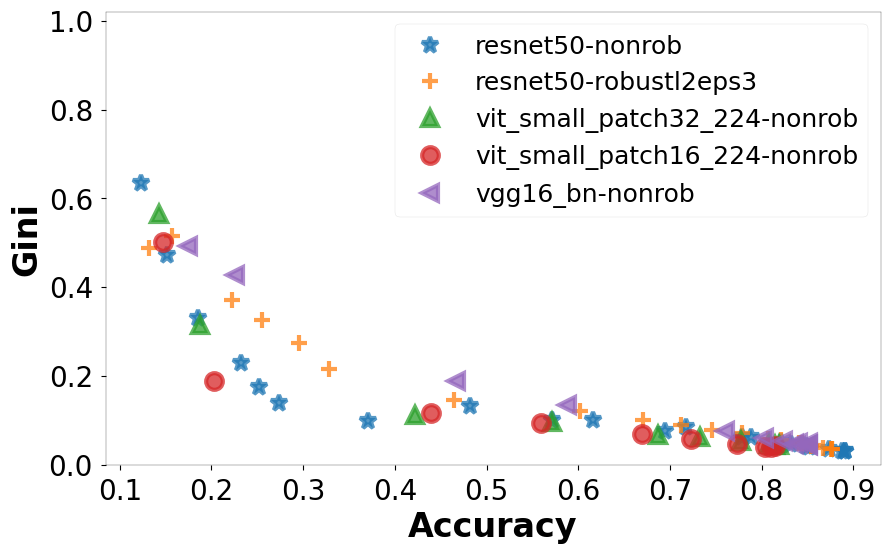

In [43]:
models_to_compare = ['resnet50-nonrob', 'resnet50-robustl2eps3', 
#                      'resnet50_mrl-nonrob',
                    'vit_small_patch32_224-nonrob', 'vit_small_patch16_224-nonrob', 'vgg16_bn-nonrob']
model_results = [(resnet50_classwise_accs, resnet50_overall),
                 (resnet50_classwise_accs, resnet50_overall),
#                  (resnet50mrl_classwise_accs, resnet50mrl_overall),
                 (vit32_classwise_accs, vit32_overall),
                 (vit16_classwise_accs, vit16_overall),
                 (vgg16_classwise_accs, vgg16_overall)
                ]
#                  (resnet50mrl_rand_classwise_accs, resnet50mrl_rand_overall)]
# appends = ['', '', '-first', '', '', ''] 
appends = ['', '', '', '', ''] 
#, '-rand']
model_str = 'resnet50_vs_vgg_vs_vit'

inset_vals = [
    {'xlim': (0.4,0.8), 'loc': 'center right', 'loc1': 2, 'loc2': 4, 'zoom': 1.},
    {'xlim': (0.15,0.35), 'loc': 'lower left', 'loc1': 2, 'loc2': 4, 'zoom': 1.25},
    {'xlim': (0.05,0.2), 'loc': 'lower left', 'loc1': 1, 'loc2': 2, 'zoom': 1.5},
    {'xlim': (0.7,0.85), 'loc': 'center', 'loc1': 1, 'loc2': 3, 'zoom': 1.5}
]

for ds_idx, ft_ds in enumerate(FINETUNING_DATASETS):
    model_wise_x, model_wise_x_frac = [], []
    model_wise_gini, model_wise_maxmin, model_wise_tv = [], [], []
    legend_vals = []
    for model, append, (model_results_classwise, model_results_overall) in \
        zip(models_to_compare, appends, model_results):
        x_vals, x_vals_frac = [], []
        ginis, maxmins, tvs = [], [], []
        if f'{model}-{ft_ds}' in model_results_overall:
            for idx, key in enumerate(sorted(model_results_overall[f'{model}-{ft_ds}'].keys())):
                x_vals.append(np.nanmean(model_results_overall[f'{model}-{ft_ds}'][key]))
                x_vals_frac.append(key if isinstance(key, float) else key/2048.)
                ginis.append(gini(model_results_classwise[f'{model}-{ft_ds}'][:,idx]))
                maxmins.append(maxmin(model_results_classwise[f'{model}-{ft_ds}'][:,idx]))
                tvs.append(tv(model_results_classwise[f'{model}-{ft_ds}'][:,idx]))
            model_wise_x.append(x_vals)
            model_wise_x_frac.append(x_vals_frac)
            model_wise_gini.append(ginis)
            model_wise_tv.append(tvs)
            model_wise_maxmin.append(maxmins)
            legend_vals.append(f'{model}{append}')
    print (ft_ds)
    plt_hp.line_plot(
        model_wise_gini, 
        'Accuracy', 'Gini', '', 
        subfolder=SOURCE_DATASET, filename=f'gini_vs_acc_{model_str}-{ft_ds}', 
        extension='png', x_vals=model_wise_x, legend_vals=legend_vals, vertical_line=None, 
        linestyles=['']*len(model_wise_gini), 
        y_lims=(0.,1.02), root_dir='.', paper_friendly_plots=True, 
        plot_inside=True, legend_location='best', savefig=True, figsize=(10,6), 
        marker=['*', '+', '^', 'o', '<'], results_subfolder_name='class_wise_errors', 
        grid_spacing=None, y_err=None, legend_ncol=None, )
#         inset=inset_vals[ds_idx])
    
#     plt_hp.line_plot(
#         model_wise_tv, 
#         'Accuracy', 'Coeff. of Variation', '', 
#         subfolder=SOURCE_DATASET, filename=f'tv_vs_acc_{model_str}-{ft_ds}', 
#         extension='png', x_vals=model_wise_x, legend_vals=legend_vals, vertical_line=None, 
#         linestyles=['']*len(model_wise_tv), 
#         y_lims=(0.,1.02), root_dir='.', paper_friendly_plots=True, 
#         plot_inside=True, legend_location='best', savefig=True, figsize=(10,6), 
#         marker=['*', '+', '^', 'o'], results_subfolder_name='class_wise_errors', 
#         grid_spacing=None, y_err=None, legend_ncol=None)
    
#     plt_hp.line_plot(
#         model_wise_tv, 
#         'Accuracy', 'Coeff. of Variation', '', 
#         subfolder=SOURCE_DATASET, filename=f'tv_vs_frac_{model_str}-{ft_ds}', 
#         extension='png', x_vals=model_wise_x_frac, legend_vals=legend_vals, vertical_line=None, 
#         linestyles=['']*len(model_wise_tv), 
#         y_lims=(0.,1.02), root_dir='.', paper_friendly_plots=True, 
#         plot_inside=True, legend_location='best', savefig=True, figsize=(10,6), 
#         marker=['*', '+', '^', 'o'], results_subfolder_name='class_wise_errors', 
#         grid_spacing=None, y_err=None, legend_ncol=None)


#     plt_hp.line_plot(
#         model_wise_gini, 
#         'Fraction', 'Gini', '', 
#         subfolder=SOURCE_DATASET, filename=f'gini_vs_frac_{model_str}-{ft_ds}', 
#         extension='png', x_vals=model_wise_x_frac, legend_vals=legend_vals, vertical_line=None, 
#         linestyles=['']*len(model_wise_gini), 
#         y_lims=(0.,1.02), root_dir='.', paper_friendly_plots=True, 
#         plot_inside=True, legend_location='best', savefig=True, figsize=(10,6), 
#         marker=['*', '+', '^', 'o'], results_subfolder_name='class_wise_errors', 
#         grid_spacing=None, y_err=None, legend_ncol=None)

#     plt_hp.line_plot(
#         model_wise_maxmin, 
#         'Accuracy', 'Maxmin', '', 
#         subfolder=SOURCE_DATASET, filename=f'maxmin_vs_acc_{model_str}-{ft_ds}', 
#         extension='png', x_vals=model_wise_x, legend_vals=legend_vals, vertical_line=None, 
#         linestyles=['']*len(model_wise_maxmin), 
#         y_lims=(0.,1.02), root_dir='.', paper_friendly_plots=True, 
#         plot_inside=True, legend_location='best', savefig=True, figsize=(10,6), 
#         marker=['*', '+', '^', 'o'], results_subfolder_name='class_wise_errors', 
#         grid_spacing=None, y_err=None, legend_ncol=None)